# Generating sections from World Ocean Database CTD profiles   with bathymetry
In oceanography, it is often advantageous to create 2-D sections from a series of 1-D profile measurements (i.e. temp(depth), salinity(depth), etc.) to understand how ocean properties are changing along a certain path.  

This notebook shows how to take in CTD profiles from the World Ocean Database and combine them with GEBCO bathymetry to generate temperature cross sections using 2D linear interpolation.  The methods described here are easily adaptable for generating salinity sections as well.  Various functions used by this program are useful for other purposes and are outlined in seperate notebooks.

Before starting:
- I have downloaded the profiles of interest from the world ocean database in netcdf format found [here](https://www.nodc.noaa.gov/OC5/SELECT/dbsearch/dbsearch.html).

- I have also downloaded the GEBCO bathymetry netcdf file for my location of interest.  This can be found [here](http://www.gebco.net/data_and_products/gridded_bathymetry_data/).

In [25]:
import numpy as np
from   netCDF4 import Dataset
import matplotlib.pyplot as plt
import scipy.interpolate
import pyproj
from mpl_toolkits.basemap import Basemap
import cmocean
%matplotlib inline

Assign directories of CTD and bathymetry datasets. List profiles of interest in order along section.

In [32]:
# Directory of CTD profiles
data_dir   = '/Projects/antarctica_ctd/ocldb1465919697.6573.CTD/'

# List of profiles of interest
profile_arr = ['wod_016492406O.nc','wod_016492405O.nc', 'wod_016492404O.nc', 'wod_016492403O.nc', \
               'wod_016492402O.nc', 'wod_016492402O.nc','wod_016492401O.nc', 'wod_016492400O.nc', \
               'wod_016492399O.nc', 'wod_016492398O.nc']

# Directory and file for bathymetry file. Load the bathy index information for later use
dir_bath  = '/Projects/antarctica_ctd/bathy/'
bath_file = 'GEBCO_2014_2D_-83.3333_-81.7949_-48.4615_-56.6667.nc' 
bath_dat  = Dataset(dir_bath + bath_file)
bath_lats = bath_dat['lat'][:]
bath_lons = bath_dat['lon'][:]

# Before analysis, lets see where the profiles were taken
( Here I have chosen profiles going inland towards the Antarctic Peninsula )

In [13]:
# Pull location from CTD files
lats = []; lons = [];
for i in range(len(profile_arr)):
    data = Dataset(data_dir+profile_arr[i])
    lats = np.append(lats, data.geospatial_lat_min)
    lons = np.append(lons, data.geospatial_lon_min)

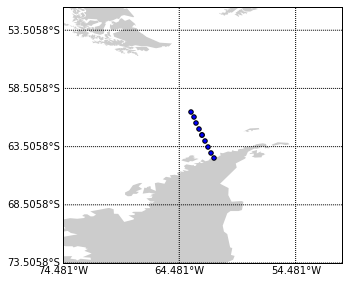

In [34]:
plt.figure(figsize=(5,5))
lat_max = np.max(lats) + 10; lat_min = np.min(lats) - 10; 
lon_min = np.min(lons) - 10 + 360; lon_max = np.max(lons) + 10 + 360
m = Basemap(projection='cyl',lon_0=210,resolution='l', llcrnrlat=lat_min,
            urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
cs = m.scatter(lats, lons, latlon=True, zorder=10); m.fillcontinents(color='0.8', lake_color='0.8');
parallels = np.arange(lat_min,lat_max,5);
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10);
meridians = np.arange(lon_min,lon_max,10.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10);

# I also need to define a few functions used to grab the bathymetry data

In [8]:
def find_nearest(arr, value):
    '''
    find_nearest:
    Takes in an array and point, returns index of the closest location 
    in the array to the point

    Inputs
    -----
    arr   = array of values (i.e. latitude)
    value = point of interest

    Returns
    -----
    idx = integer index of location 

    '''
    idx = (np.abs(arr-value)).argmin()
    return idx

def ptsarr(lat1, lon1, lat2, lon2):
    '''
    ptsarr:
    Takes in pair of points, returns latlon points along great circle between them

    Input
    -----
    lat1, lon1, lat2, lon2 = lat/lon location of two points of interest (-90 < lat <90,  -180 < lon < 180)

    Returns
    -------
    lonlats = list of lat/lon pairs

    '''
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(lon1, lat1, lon2, lat2)
    lonlats = g.npts(lon1, lat1, lon2, lat2, 1 + int(dist/1000))
    lonlats.insert(0, (lon1, lat1))
    lonlats.append((lon2, lat2))
    return lonlats, dist/1000
    
def pts2dist(lat1, lon1, lat2, lon2):
    '''
    pts2dist:
    Similar as above, slightly faster as it only returns distance between two points
    ''' 
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(lon1, lat1, lon2, lat2)
    return  dist/1000

def pts2elevprofile(lat1, lon1, lat2, lon2):
    '''
    pts2elevprofile:
    Takes two points and returns ocean depth at points between them

    Input
    -----
    lat1, lon1, lat2, lon2 = lat/lon location of two points of interest (-90 < lat <90,  -180 < lon < 180)

    Output
    -----
    1-D array of longitudes, 1D array of latitudes, 1D array of elevations
    dist = distance between source and measruemetn 
    '''
    points, dist = ptsarr(lat1, lon1, lat2, lon2)
    elev_arr = []
    for locs in points:
        lon = locs[0]
        lat = locs[1]
        idx_lat  = find_nearest(bath_lats, lat)
        idx_lon  = find_nearest(bath_lons, lon)
        elev     = bath_dat['elevation'][idx_lat, idx_lon]
        elev_arr = np.append(elev_arr, elev)
    points = np.array(points)
    dist_arr    = dist / (len(elev_arr)-1) * np.ones(len(elev_arr))
    dist_arr[0] = 0

    return points[:,0], points[:, 1], elev_arr, dist_arr.cumsum()


def find_max_depth(data_dir, profile_arr):

    '''
    Find max depth from a bunch of ctd profiles.  Useful for 
    determining max size of grid space

    '''
    old_max = 0 
    for i in range(len(profile_arr)):
        data      = Dataset(data_dir+profile_arr[i])
        max_depth = data.variables['z'][:].max()
        if max_depth > old_max:
            old_max = max_depth
    return old_max


## This is the main method for interpolating between profiles onto a regular grid

In [21]:
def calculate_section(profile_arr):
    '''
    calculate_section:
    Takes array of CTD profiles in order of the section of interest and outputs interpolated
    grid for entire cross section as well as bathymetry across the section. Also outputs
    the location and depth of the casts along the section (black lines on final plot). 

    Input
    -----
    profile_arr = list of strings referencing .nc CTD files

    Output
    -----
    cast_plot_locs = information on cast locations along profile (used to plot cast locations)
    interp_data    = interpolated grid {x, y, temp} 
    bathy_data     = bathymetry data along section {x, z}
    '''     
    # Initialize variables
    max_depth_list   = []
    distance_list    = 0
    distance_running = 0
    dist_running_bathy = np.array([0])
    depth_array        = 0
    i = 0
    
    # Calculate maximum depth to use in the interpolation space
    max_depth = find_max_depth(data_dir, profile_arr)    
    
    for i in range (1, len(profile_arr)):
        print("Calculating between : ",profile_arr[i-1], " and : ", profile_arr[i])
        
        # Read in profile data
        data_left  = Dataset(data_dir+profile_arr[i-1])
        data_right = Dataset(data_dir+profile_arr[i])
        if i == 1:
            depth_left = data_left.variables['z'][:]
            temp_left  = data_left.variables['Temperature' ][:]
            lat_left   = data_left.geospatial_lat_min
            lon_left   = data_left.geospatial_lon_min
        else:
            depth_left = depth_right
            temp_left  = temp_right
            lat_left   = lat_right
            lon_left   = lon_right
            
        depth_right = data_right.variables['z'][:]
        temp_right  = data_right.variables['Temperature' ][:]
        lat_right   = data_right.geospatial_lat_min
        lon_right   = data_right.geospatial_lon_min
                
        # Now we need to calculate distance between casts in metric units for plotting  
        distance = pts2dist(lat_left, lon_left, lat_right, lon_right)
        distance_running += distance # Running distance along entire section
        distance_list = np.append(distance_list, distance_running) # Array of location of casts in section for plotting
    
        # Calculates grid of points to be interpolated on between casts
        disc_x = 100 # m between interpolated points (distance)
        disc_y = 50  # m between interpolated points (depth   )
        
        grid_x, grid_y = np.meshgrid(np.arange(distance_list[i-1], distance_running + disc_x/1000., disc_x/1000.), np.arange(0, max_depth, disc_y))  
        
        # Proper locations for full section
        x_arr = np.append(distance_list[i-1] * np.ones(len(depth_left)), distance_running * np.ones(len(depth_right)))
        y_arr = np.append(depth_left, depth_right)  
        temps = np.append(temp_left, temp_right)
     
        loc_arr = np.zeros((2, len(x_arr)))
        loc_arr[0,:] = x_arr
        loc_arr[1,:] = y_arr
        
        # ============== Perform interpolation (linear) =================== #
        gridded_dat = scipy.interpolate.griddata(loc_arr.T, temps, (grid_x, grid_y), method='linear')
    
        if i == 1:
            max_depth_list = np.max(depth_left)
            max_depth_list = np.append(max_depth_list, np.max(depth_right))
            gridout_x = grid_x
            gridout_y = grid_y
            data_out  = gridded_dat
        else:
            max_depth_list = np.append(max_depth_list, np.max(depth_right))  
            gridout_x = np.append(gridout_x, grid_x,     axis=1)
            gridout_y = np.append(gridout_y, grid_y,     axis=1)
            data_out  = np.append(data_out, gridded_dat, axis=1)
        
        
        # ================ Get bathymetry data between profile locations ================ #
        lat_arr, lon_arr, z_arr, dist_along_line = pts2elevprofile(lat_left, lon_left, lat_right, lon_right)
        depth_array = np.append(depth_array, z_arr)
        dist_running_bathy = np.append(dist_running_bathy, dist_along_line+dist_running_bathy[-1])
   
    # Make these neater to send to plotting function 
    bathy_data = {}
    bathy_data['dist' ] = dist_running_bathy
    bathy_data['depth'] = depth_array
    cast_plot_locs = {}
    cast_plot_locs['depth'] = max_depth_list
    cast_plot_locs['dist']  = distance_list
    interp_data = {}
    interp_data['xgrid'] = gridout_x
    interp_data['ygrid'] = gridout_y
    interp_data['data' ] = data_out
    return cast_plot_locs, interp_data, bathy_data

## My plotting function which includes bathymetry

In [30]:
def plot_profile(cast_plot_locs, interp_data, bathy_data):
    print("## == Generating figure == ##")
    plt.figure(figsize=(14,5))
    for i in range(0, len(cast_plot_locs['dist'])):
        plt.plot(cast_plot_locs['dist'][i]*np.array([1,1]), 
                 np.array([0, -cast_plot_locs['depth'][i]]), c='k', zorder=10)
        plt.scatter(cast_plot_locs['dist'][i], 0, marker="v", s=30)
    
    # Determine plot levels
    interp_data['data'] = np.ma.masked_invalid(interp_data['data'])
    temp_max = np.max(interp_data['data'])
    temp_min = np.min(interp_data['data'])
    levels = np.arange(temp_min, temp_max+0.1, 0.1)        
    cmap = cmocean.cm.temperature
    
    cs = plt.contourf(interp_data['xgrid'], -1*interp_data['ygrid'], interp_data['data'],
                     levels, cmap=cmap)
    cs.set_clim(temp_min, temp_max)
    plt.xlabel('Distance along transect (km)')
    plt.ylabel('Elevation (m)')
    plt.colorbar(label='Temp (degC)')
    
    if bathy_data != "off":
        # continuous function to allow plotting black fill
        fn = scipy.interpolate.interp1d(bathy_data['dist'][1::], bathy_data['depth'][1::])
        xx = np.arange(0, np.max(bathy_data['dist']), .1)
        bathy_interp = fn(xx)
        bathy_interp = np.ma.masked_invalid(bathy_interp)
        plt.plot(xx, bathy_interp, c='k')
        plt.fill_between(xx, bathy_interp, np.ma.min(bathy_interp)-50, color='k')

    plt.xlim([0, np.max(interp_data['xgrid'])])
    plt.ylim([np.ma.min(bathy_interp-50), 20])

# Run interpolation and plot
It is worth noting here that interpolation is only done between each neighboring profiles.  (i.e. for section of profiles A, B, C, D, the interpolation between B and C does not know about profiles A or D).  You still must be wary using this method and remember that the interpolation may lead to features that are not necessarily physical but are a good guess at what is happening across the profile.  

Calculating between :  wod_016492406O.nc  and :  wod_016492405O.nc
Calculating between :  wod_016492405O.nc  and :  wod_016492404O.nc
Calculating between :  wod_016492404O.nc  and :  wod_016492403O.nc
Calculating between :  wod_016492403O.nc  and :  wod_016492402O.nc
Calculating between :  wod_016492402O.nc  and :  wod_016492402O.nc
Calculating between :  wod_016492402O.nc  and :  wod_016492401O.nc
Calculating between :  wod_016492401O.nc  and :  wod_016492400O.nc
Calculating between :  wod_016492400O.nc  and :  wod_016492399O.nc
Calculating between :  wod_016492399O.nc  and :  wod_016492398O.nc
## == Generating figure == ##


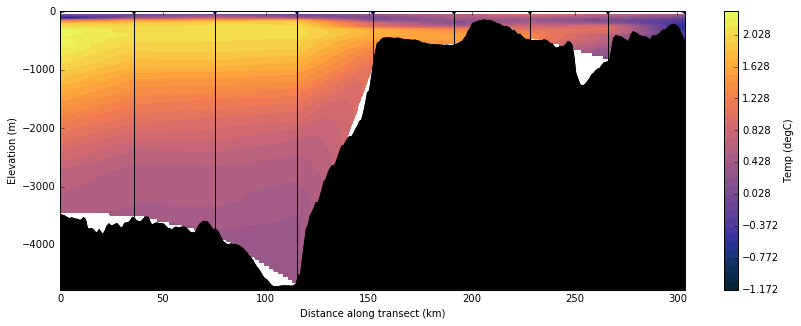

In [31]:
cast_plot_locs, interp_data, bathy_data = calculate_section(profile_arr)

plot_profile(cast_plot_locs, interp_data, bathy_data)